<a href="https://colab.research.google.com/github/gpandji/stock-prediction/blob/Prediction-experiments/LMT_predictionGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-938512186.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  lmt = yf.download("LMT", start="2000-01-01", end="2025-02-07")
[*********************100%***********************]  1 of 1 completed


Creating features...
✓ Dataset ready: 6107 rows, 21 columns
Using 15 features
Training samples: 4885
Testing samples: 1222

Training Gradient Boosting model...
✓ Training complete!

MODEL PERFORMANCE (7 trading days ahead)
Training MAE: $1.00
Testing MAE:  $87.16
Training R²:  1.000
Testing R²:   -1.615

Average error: 22.28% of stock price

BASELINE (Predict future close = today's close)
Baseline MAE: $10.60

TOP 10 MOST IMPORTANT FEATURES
       Feature  Importance
        MA_200    0.396763
         MA_50    0.326007
   Close_lag10    0.160457
    Close_lag1    0.094539
         MA_10    0.018962
    Close_lag5    0.001897
Volatility_30d    0.000393
         Month    0.000343
           RSI    0.000233
Volatility_10d    0.000151


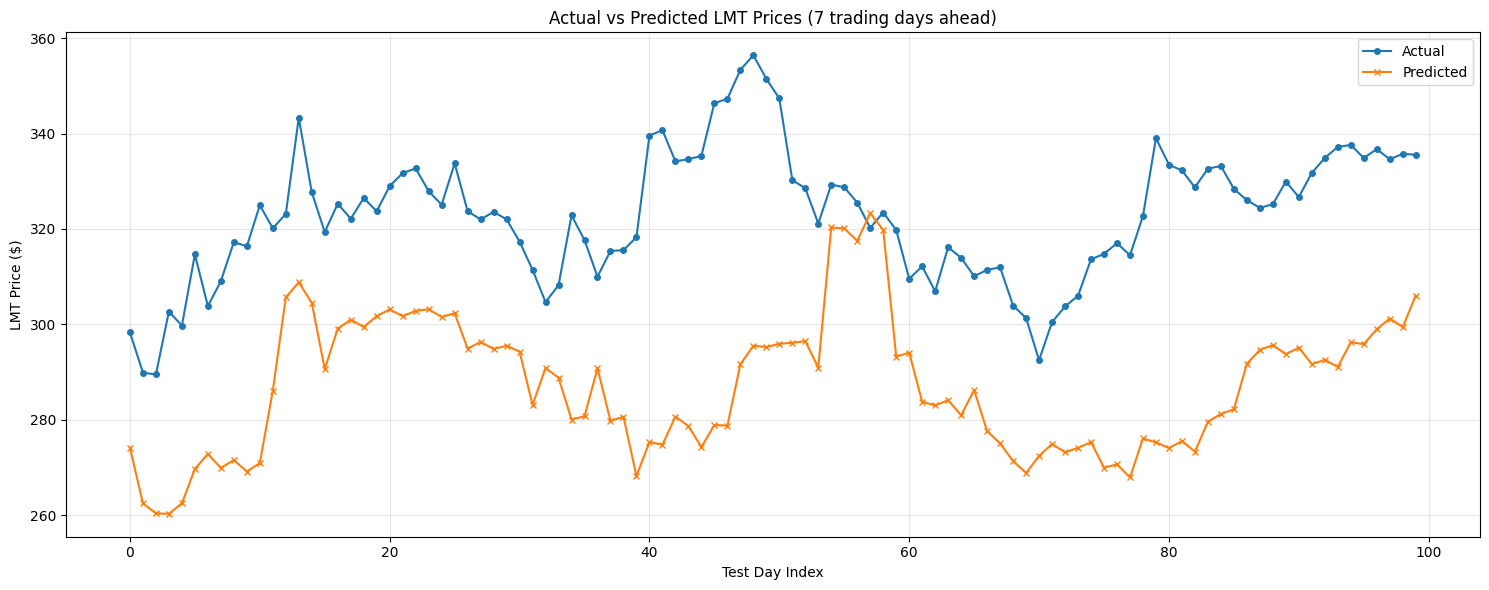


NEXT 7-TRADING-DAY PREDICTION
Current LMT price:           $444.35
Predicted price (t+7 rows):  $278.68
Expected change:             -37.28%

FIRST 20 TEST PREDICTIONS
Feature_Date Target_Date  Actual_Price  Predicted_Price   Error_$   Error_%
  2020-03-19  2020-03-19    298.317657       274.124328 24.193330  8.109922
  2020-03-20  2020-03-20    289.851746       262.452802 27.398944  9.452744
  2020-03-23  2020-03-23    289.484009       260.353398 29.130611 10.062943
  2020-03-24  2020-03-24    302.687469       260.261780 42.425690 14.016335
  2020-03-25  2020-03-25    299.728638       262.462090 37.266548 12.433429
  2020-03-26  2020-03-26    314.650970       269.659293 44.991677 14.298916
  2020-03-27  2020-03-27    303.816254       272.808558 31.007696 10.206069
  2020-03-30  2020-03-30    309.058319       269.886133 39.172186 12.674691
  2020-03-31  2020-03-31    317.259125       271.532646 45.726479 14.412975
  2020-04-01  2020-04-01    316.352692       269.126425 47.226267 14.92

/tmp/ipython-input-938512186.py:185: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(lmt["Close"].iloc[-1])


In [1]:
# =========================
# LMT 7-Day Ahead Prediction (FIXED: no data leakage + cleaner workflow)
# =========================

!pip install yfinance scikit-learn -q

import yfinance as yf
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Download data
# -------------------------
print("Downloading LMT data...")
lmt = yf.download("LMT", start="2000-01-01", end="2025-02-07")

print("Creating features...")

# -------------------------
# Feature engineering
# -------------------------
# Price lags
lmt["Close_lag1"]  = lmt["Close"].shift(1)
lmt["Close_lag5"]  = lmt["Close"].shift(5)
lmt["Close_lag10"] = lmt["Close"].shift(10)

# Returns
lmt["Return_1d"]  = lmt["Close"].pct_change(1)
lmt["Return_5d"]  = lmt["Close"].pct_change(5)
lmt["Return_20d"] = lmt["Close"].pct_change(20)

# Moving averages
lmt["MA_10"]  = lmt["Close"].rolling(10).mean()
lmt["MA_50"]  = lmt["Close"].rolling(50).mean()
lmt["MA_200"] = lmt["Close"].rolling(200).mean()

# Volatility
lmt["Volatility_10d"] = lmt["Return_1d"].rolling(10).std()
lmt["Volatility_30d"] = lmt["Return_1d"].rolling(30).std()

# RSI (simple rolling-average RSI)
def calculate_rsi(series, periods=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lmt["RSI"] = calculate_rsi(lmt["Close"])

# Calendar features
lmt["Month"] = lmt.index.month
lmt["Quarter"] = lmt.index.quarter
lmt["DayOfWeek"] = lmt.index.dayofweek

# Target: predict 7 trading days ahead (shift is row-based)
lmt["Target"] = lmt["Close"].shift(-7)

# Drop NaNs from rolling/shift operations
lmt = lmt.dropna()

print(f"✓ Dataset ready: {lmt.shape[0]} rows, {lmt.shape[1]} columns")

# -------------------------
# Prepare X / y
# -------------------------
features = [
    "Close_lag1", "Close_lag5", "Close_lag10",
    "Return_1d", "Return_5d", "Return_20d",
    "MA_10", "MA_50", "MA_200",
    "Volatility_10d", "Volatility_30d",
    "RSI",
    "Month", "Quarter", "DayOfWeek"
]

print(f"Using {len(features)} features")

X = lmt[features]
y = lmt["Target"]

# -------------------------
# Time-based split (NO shuffle)
# -------------------------
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# -------------------------
# Scale features (FIT ONLY ON TRAIN to avoid leakage)
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------
# Train model
# -------------------------
print("\nTraining Gradient Boosting model...")
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)
model.fit(X_train_scaled, y_train)
print("✓ Training complete!")

# -------------------------
# Evaluate
# -------------------------
y_pred_train = model.predict(X_train_scaled)
y_pred_test  = model.predict(X_test_scaled)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae  = mean_absolute_error(y_test,  y_pred_test)
train_r2  = r2_score(y_train, y_pred_train)
test_r2   = r2_score(y_test,  y_pred_test)

print("\n" + "="*50)
print("MODEL PERFORMANCE (7 trading days ahead)")
print("="*50)
print(f"Training MAE: ${train_mae:.2f}")
print(f"Testing MAE:  ${test_mae:.2f}")
print(f"Training R²:  {train_r2:.3f}")
print(f"Testing R²:   {test_r2:.3f}")

avg_price = y_test.mean()
error_pct = (test_mae / avg_price) * 100
print(f"\nAverage error: {error_pct:.2f}% of stock price")

# -------------------------
# Baseline comparison (optional but very useful)
# Baseline: predict Target ~= today's Close
# (for each row in test, baseline predicts future close equals current close)
# -------------------------
baseline_pred = lmt["Close"].iloc[split:split+len(y_test)].values
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print("\n" + "="*50)
print("BASELINE (Predict future close = today's close)")
print("="*50)
print(f"Baseline MAE: ${baseline_mae:.2f}")

# -------------------------
# Feature importance
# -------------------------
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
print(importance_df.head(10).to_string(index=False))

# -------------------------
# Visualize (first 100 test points)
# -------------------------
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label="Actual", marker="o", markersize=4)
plt.plot(y_pred_test[:100], label="Predicted", marker="x", markersize=4)
plt.xlabel("Test Day Index")
plt.ylabel("LMT Price ($)")
plt.title("Actual vs Predicted LMT Prices (7 trading days ahead)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------
# Predict next week (from latest available row)
# -------------------------
latest_data = scaler.transform(X.iloc[[-1]])  # transform latest row using train-fitted scaler
next_week_prediction = model.predict(latest_data)[0]
current_price = float(lmt["Close"].iloc[-1])

change_pct = ((next_week_prediction - current_price) / current_price) * 100

print("\n" + "="*50)
print("NEXT 7-TRADING-DAY PREDICTION")
print("="*50)
print(f"Current LMT price:           ${current_price:.2f}")
print(f"Predicted price (t+7 rows):  ${next_week_prediction:.2f}")
print(f"Expected change:             {change_pct:+.2f}%")

# -------------------------
# Detailed comparison with dates (test set)
# NOTE: prediction date here is the feature date; target is 7 trading days later
# -------------------------
test_dates = lmt.index[split:split+len(y_test)]

comparison_with_dates = pd.DataFrame({
    "Feature_Date": test_dates,                # date used to compute features
    "Target_Date":  test_dates + pd.Timedelta(days=0),  # index rows are trading days; not exact calendar offset
    "Actual_Price": y_test.values,
    "Predicted_Price": y_pred_test,
    "Error_$": y_test.values - y_pred_test,
    "Error_%": ((y_test.values - y_pred_test) / y_test.values * 100)
})

print("\n" + "="*80)
print("FIRST 20 TEST PREDICTIONS")
print("="*80)
print(comparison_with_dates.head(20).to_string(index=False))

print("\n" + "="*80)
print("LAST 20 TEST PREDICTIONS (Most Recent)")
print("="*80)
print(comparison_with_dates.tail(20).to_string(index=False))
